In [1]:
# Imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# read and take a peak at data_set
Wage = pd.read_csv("Wage.csv")

Wage.head()

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In order to focus on spline regression in detail, we will use only 'age' as the independent variable to predict the wage (dependent variable).

In [3]:
X = Wage['age']
y = Wage['wage']

In [4]:
# Dividing data into train and validation datasets
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.30, random_state = 1)

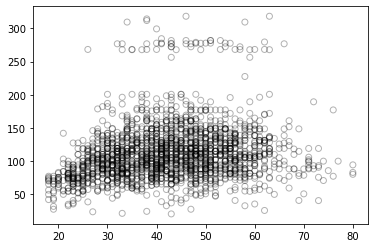

In [5]:
# Visualize the relationship between age and wage
import matplotlib.pyplot as plt
plt.scatter(train_x, train_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.show()

As we are using only age to predict the wage of the employees, we will implement a simple linear regression (Y=beta0 +beta1X1) on the training dataset and calculate the error (RMSE) on the test dataset.

In [6]:
from sklearn.linear_model import LinearRegression

# Fitting linear regression model
x = train_x.values.reshape(-1,1)
model = LinearRegression()
model.fit(x,train_y)
print(model.coef_)
print(model.intercept_)

[0.72106369]
80.58924709257079


In [7]:
# Compute the RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

test_x = test_x.values.reshape(-1,1)
pred = model.predict(test_x)

rms = sqrt(mean_squared_error(test_y, pred))
print(rms)

41.413847519576784


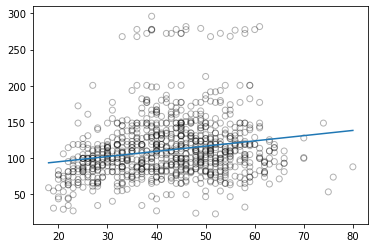

In [8]:
# Visualisation
linear_regr = np.linspace(test_x.min(),test_x.max())
linear_regr = linear_regr.reshape(-1,1)
plot = model.predict(linear_regr)

plt.scatter(test_x, test_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(linear_regr, plot)
plt.show()

We can infer from the above graph that linear regression is not capturing all the signals available and is not the best method for solving this wage prediction.

### Polynomial Regression

The standard method to extend linear regression to a non-linear relationship between the dependent and independent variables is to replace the linear model with a polynomial function. As we increase the power value, the curve obtained contains high oscillations which will lead to shapes that are over-flexible. Such curves lead to over-fitting.

In [9]:
# Generating weights for polynomial function with degree 2
weights = np.polyfit(train_x, train_y, 2)
print(weights)

[-0.04971386  5.04449578 -6.60055953]


In [10]:
# Generating model with the given weights
poly_model = np.poly1d(weights)

In [11]:
# Prediction on test set
pred = poly_model(test_x)

In [12]:
# RMSE
test_x = test_x.reshape(-1,1)
pred = poly_model(test_x)

rms = sqrt(mean_squared_error(test_y, pred))
print(rms)

40.34478823806699


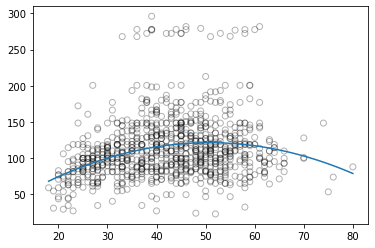

In [13]:
# Visualisation
poly_regr = np.linspace(test_x.min(),test_x.max())
plot = poly_model(poly_regr)

plt.scatter(test_x, test_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(linear_regr, plot)
plt.show()

### Step Functions

In [14]:
# Dividing the data into 5 bins
wage_cut, bins = pd.cut(train_x, 5, retbins=True, right=True)
wage_cut.value_counts(sort=False)

(17.938, 30.4]    363
(30.4, 42.8]      706
(42.8, 55.2]      735
(55.2, 67.6]      259
(67.6, 80.0]       37
Name: age, dtype: int64

One of the most common piecewise functions is a Step function. Step function is a function which remains constant within the interval. We can fit individual step functions to each of the divided portions in order to avoid imposing a global structure. Here we break the range of X into bins, and fit a different constant in each bin. As you may recall from the lecture, if we place K different knots throughout the range of X, then we will end up fitting K + 1 different cubic polynomials.

In [15]:
wage_steps = pd.concat([train_x, wage_cut, train_y], keys=['age','age_cuts','wage'], axis=1)

# Create dummy variables for the age groups, 
wage_steps_dummies = pd.get_dummies(wage_cut)
wage_steps_dummies.head()

,"(17.938, 30.4]","(30.4, 42.8]","(42.8, 55.2]","(55.2, 67.6]","(67.6, 80.0]"
1045,0,0,1,0,0
2717,0,0,1,0,0
2835,0,1,0,0,0
2913,0,0,0,1,0
959,0,0,1,0,0


In [16]:
# Fitting Generalized linear models
fit_glm = sm.GLM(wage_steps.wage, wage_steps_dummies).fit()

In [17]:
# Binning validation set into same 5 bins
bin_mapping = np.digitize(test_x, bins) 
bin_mapping = bin_mapping.ravel()
X_test = pd.get_dummies(bin_mapping)

# Removing any outliers
X_test = pd.get_dummies(bin_mapping).drop([5], axis=1)

# Prediction
pred_glm = fit_glm.predict(X_test)

# Calculating RMSE
from sklearn.metrics import mean_squared_error 
from math import sqrt 
rms = sqrt(mean_squared_error(test_y, pred_glm)) 
print(rms)

41.56839614902859


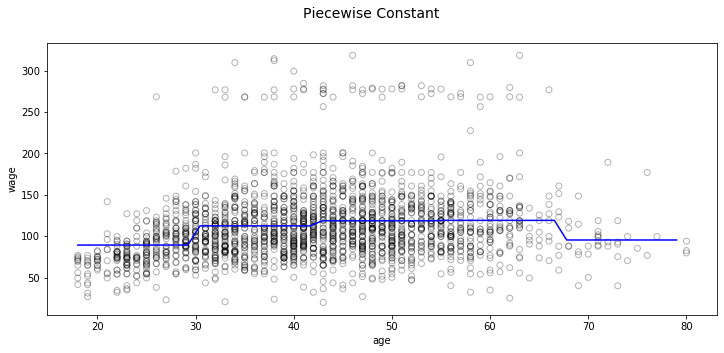

In [18]:
# Generate the polynomial model
poly = np.linspace(test_x.min(),test_x.max()-1) 
bin_mapping = np.digitize(poly, bins) 
X_test = pd.get_dummies(bin_mapping) 
pred = fit_glm.predict(X_test)

# Visualisation
fig, (ax1) = plt.subplots(1,1, figsize=(12,5))
fig.suptitle('Piecewise Constant', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(train_x, train_y, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(poly, pred, c='b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
plt.show()

### Cubic and Natural Cubic Splines

Instead of fitting a constant function over different bins across the range of X, piecewise polynomial regression involves fitting separate low-degree polynomials over different regions of X. As we use lower degrees of polynomials, we don’t observe high oscillations of the curve around the data. 

Cubic spline is a piecewise polynomial with a set of extra constraints (continuity, continuity of the first derivative, and continuity of the second derivative).

Here we'll use a new library for this purpose called patsy. patsy is a Python package for describing statistical models (especially linear models, or models that have a linear component) and building design matrices. It is closely inspired by and compatible with the formula mini-language used in R

In [20]:
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Generating cubic spline with 3 knots at 25, 40 and 60
transformed_x = dmatrix("bs(train, knots=(25,40,60), degree=3, include_intercept=False)", {"train": train_x},return_type='dataframe')

# Fitting GLM on the transformed dataset
fit_glm = sm.GLM(train_y, transformed_x).fit()

In [21]:

# Prediction
pred_glm = fit_glm.predict(dmatrix("bs(valid, knots=(25,40,60), include_intercept=False)", {"valid": test_x}, return_type='dataframe'))

# Calculating RMSE 
rms = sqrt(mean_squared_error(test_y, pred_glm))
print(rms)


40.26785675024388


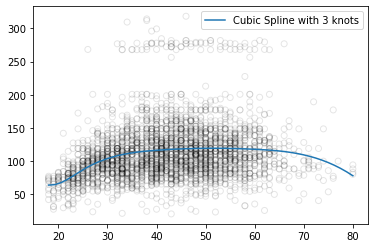

In [22]:
# Visualisation
lin = np.linspace(test_x.min(),test_x.max())
pred_glm = fit_glm.predict(dmatrix("bs(xp, knots=(25,40,60), include_intercept=False)", {"xp": lin}, return_type='dataframe'))


plt.scatter(Wage.age, Wage.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(lin, pred_glm, label='Cubic Spline with 3 knots')
plt.legend()
plt.show()

#### Natural spline

A natural cubic spline adds additional constraints, namely that the function is linear beyond the boundary knots. This constrains the cubic and quadratic parts there to 0, each reducing the degrees of freedom by 2. That’s 2 degrees of freedom at each of the two ends of the curve

In [23]:
# Generating natural cubic spline
transformed_x = dmatrix("cr(train,df = 3)", {"train": train_x}, return_type='dataframe')
fit_spline = sm.GLM(train_y, transformed_x).fit()

In [24]:
# Calculating RMSE

pred_spline = fit_spline.predict(dmatrix("cr(valid, df=3)", {"valid": test_x}, return_type='dataframe'))
rms = sqrt(mean_squared_error(test_y, pred_spline))
print(rms)

40.32523558815493


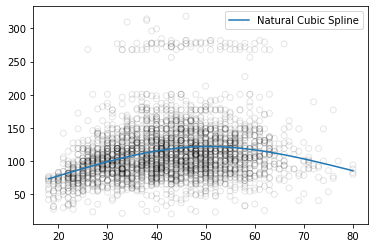

In [25]:
#Visualization

lin = np.linspace(test_x.min(),test_x.max())
pred_spline = fit_spline.predict(dmatrix("cr(xp, df=3)", {"xp": lin}, return_type='dataframe'))

plt.scatter(Wage.age, Wage.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(lin, pred_spline, label='Natural Cubic Spline')
plt.legend()
plt.show()